In this notebook we connect the hyperexcitable ridge of CA3 PCs with an inhibitory population. Our goal is explore how the connections between the PCs and INHs control the speed and activity level of the ridge propagation.

In [1]:
%reset -f
%matplotlib inline
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import os

import aux
from ntwk import LIFNtwk, cxns_pcs_rcr, ridge_h, sample_vs_gs_init
from plot import raster, set_font_size

import PARAMETERS as P

cc = np.concatenate

## top level save directory
SAVE_DIR = 'sims/balance'

## excitation-only simulations
EXC_DIR = os.path.join(SAVE_DIR, 'exc')

EXC_PATH_TIME = os.path.join(EXC_DIR, 'time.npy')
EXC_PRFX_NTWK = os.path.join(EXC_DIR, 'ntwk')

# EC->PC weight dstr vs dst to rat pos
EXC_PATH_W_N_PC_EC_VS_DIST = os.path.join(EXC_DIR, 'w_n_pc_ec_vs_dist.npy')

# initial Vm and G_N dstrs for diff EC rates
EXC_PRFX_V_0_G_0_VS_EC_RT = os.path.join(EXC_DIR, 'v_0_g_0/ec_rt')

## inhibitory-only simulations
INH_DIR = os.path.join(SAVE_DIR, 'inh')

# INH population response to stochastic inputs

We now explore the potential that a pool of inhibitory neurons might have to bring the activity propagation into a precisely controllable regime.

### Dependence of INH response to PC inputs on distribution of PC-->INH cxn strengths

For several different PC-->INH cxn strengths, we measure the population response to different PC spking rates.

In [2]:
# POPULATION GEOMETRY AND STATS
RIDGE_SHAPE = (6, 0.25)  # m
PC_DENS = 1000  # per m^2
P_INH = 0.1

# PC->INH CONNECTIVITY
P_A_INH_PC = 0.1
WS_A_INH_PC = [
    0.002, 0.003, 0.004, 0.005, 0.007,
    0.009, 0.011, 0.013, 0.015, 0.017, 0.019
]

# PC ACTIVATION
PC_SPK_RATES = [3, 7, 11, 15, 19, 23, 27]
PC_SPK_RATE_DUR = 0.25
DUR = PC_SPK_RATE_DUR * len(PC_SPK_RATES)

# make ridge
hx = aux.load(EXC_PATH_W_N_PC_EC_VS_DIST)
pfcs, ws_n_pc_ec = ridge_h(RIDGE_SHAPE, PC_DENS, hx)

# get inh population
N_PC = pfcs.shape[1]
N_INH = np.random.poisson(N_PC/(1/P_INH - 1))

print('N_PC = {}'.format(N_PC))
print('N_INH = {}'.format(N_INH))

# intrinsic cell properties
ntwk_kwargs = {
    # intrinsic cell properties
    't_m': P.T_M_INH,
    'e_l': P.E_L_INH,
    'v_th': P.V_TH_INH,
    'v_reset': P.V_RESET_INH,
    't_r': P.T_R,
    # synaptic properties
    'es_syn': {'AMPA': P.E_A},
    'ts_syn': {'AMPA': P.T_A},
    # connectivity
    'ws_rcr': {'AMPA': np.zeros((N_INH, N_INH))},
}

# time vector and spks_up
t = np.arange(0, DUR, P.DT)
spks_up = np.zeros((len(t), N_PC))

for ctr, rate in enumerate(PC_SPK_RATES):
    
    start = ctr*PC_SPK_RATE_DUR
    end = (ctr+1)*PC_SPK_RATE_DUR
    mask = (start <= t) & (t < end)
    
    spks_up[mask, :] = np.random.binomial(1, rate*P.DT, (mask.sum(), N_PC))

N_PC = 1565
N_INH = 155


In [3]:
# run ntwk sim for each PC->INH cxn weight
rsps = []
vs_init = P.E_L_INH * np.ones(N_INH)
cx_up_a = np.random.binomial(1, P_A_INH_PC, (N_INH, N_PC))

for w_a_inh_pc in WS_A_INH_PC:
    
    # build ntwk
    ntwk_kwargs_ = deepcopy(ntwk_kwargs)
    ntwk_kwargs_['ws_up'] = {'AMPA': w_a_inh_pc * cx_up_a}

    ntwk = LIFNtwk(**ntwk_kwargs_)

    # run ntwk and save response
    rsp = ntwk.run(spks_up=spks_up, dt=P.DT, vs_init=vs_init)
    rsps.append(rsp)

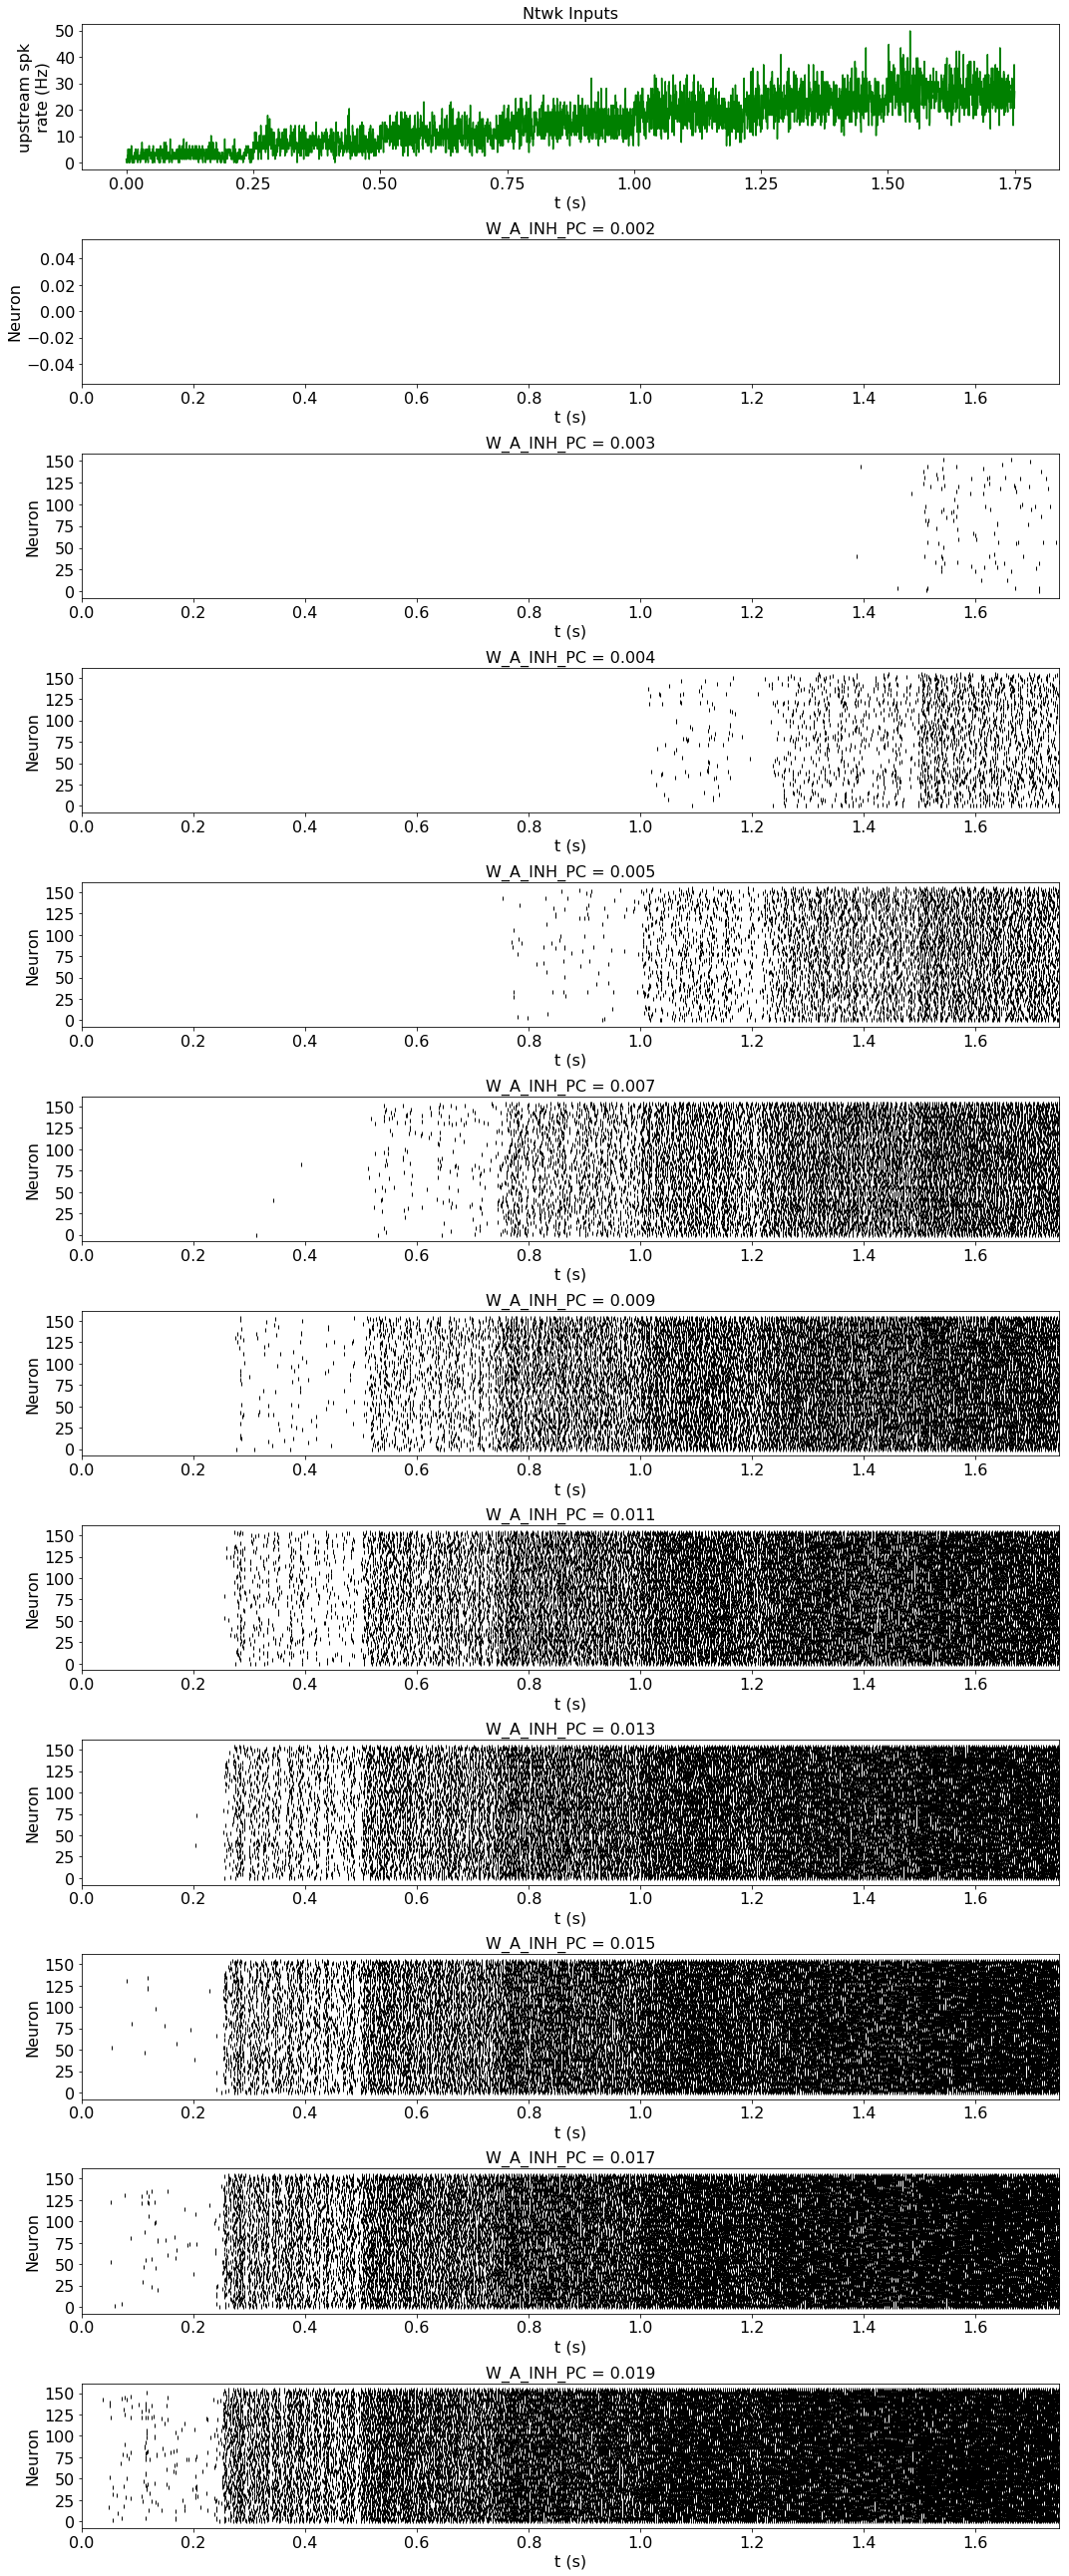

In [4]:
# plot rasters
n_axs = len(rsps) + 1
fig_size = (15, 3 * n_axs)
fig, axs = plt.subplots(n_axs, 1, figsize=fig_size, tight_layout=True, squeeze=False)
axs = axs[:, 0]

axs[0].plot(t, spks_up.sum(1)/P.DT/N_PC, color='g')

axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('upstream spk\nrate (Hz)')
axs[0].set_title('Ntwk Inputs')

for w_a_inh_pc, rsp, ax in zip(WS_A_INH_PC, rsps, axs[1:]):
    
    raster(ax, t, rsp.spks, lw=1, zorder=1)
    ax.set_title('W_A_INH_PC = {}'.format(w_a_inh_pc))
    
for ax in axs:
    set_font_size(ax, 16)

This shows how setting the PC->INH cxn weight effectively changes the minimum input required for the INH ntwk to respond.

# INH response to HX PC ridge activity propagation

Instead of driving the INH population with Bernoulli PC spikes, we now drive it with spikes generated from activity propagating along the HX PC ridge. However, we do not connect the INH population back to the PCs yet. Our goal is to demonstrate, for a few PC ridges (varying in their local connectivity statistics), how the INH response depends on the PC->INH connectivity.

In [5]:
# POPULATION GEOMETRY AND STATS
RIDGE_SHAPE = (6, 0.25)
PC_DENS = 1000
P_INH = 0.1

# PC-PC CX PARAMS
Z_PC = 0.8
L_PC = 0.2

# PC->INH CX PARAMS
P_A_INH_PC = 0.1
WS_A_INH_PC = [.001, .003, .005, .009, .013, 0.017, 0.019]

# AFTERHYPERPOLARIZATION
W_AHP = 1

# INPUTS
STIM = (0.01, 0.012)
N_STIM = 50
RATE_PL = 5000
RATE_EC = 35

# SIMULATION
DUR = 0.08

# make ridge with place fields
hx = aux.load(EXC_PATH_W_N_PC_EC_VS_DIST)
pfcs, ws_n_pc_ec = ridge_h(RIDGE_SHAPE, PC_DENS, hx)

# get inh population size
N_PC = pfcs.shape[1]
N_INH = np.random.poisson(N_PC/(1/P_INH - 1))
N = N_PC + N_INH

# sort nrns by distance to x-coord as well as 
# left-most point on ridge, which is
# the order they'll be recruited into the initial stim
x_order = np.argsort(pfcs[0])
stim_order = np.argsort(
    np.sqrt((pfcs[0] + (RIDGE_SHAPE[0]/2))**2 + pfcs[1]**2))

# make upstream connectivity matrix (N, 2*N_PC)
ws_up_a = P.W_A_PC_PL * np.eye(N_PC)
ws_up_n = np.diag(ws_n_pc_ec)
ws_up = {}

# ampa inputs from PL
w_up_a = np.zeros((N, 2*N_PC))
w_up_a[:N_PC, :] = cc([ws_up_a, np.zeros((N_PC, N_PC))], axis=1)

# nmda inputs from EC
w_up_n = np.zeros((N, 2*N_PC))
w_up_n[:N_PC, :] = cc([np.zeros((N_PC, N_PC)), ws_up_n], axis=1)

# make recurrent connectivity
w_rcr_a = np.zeros((N, N))
w_rcr_n = np.zeros((N, N))

# local PC->PC exc cxs
# (PC->INH cxs will be added inside loop)
w_rcr_a[:N_PC, :N_PC] = P.W_A_PC_PC*cxns_pcs_rcr(pfcs, Z_PC, L_PC)

# fixed ntwk params
t_m = cc([np.repeat(P.T_M_PC, N_PC), np.repeat(P.T_M_INH, N_INH)])
e_l = cc([np.repeat(P.E_L_PC, N_PC), np.repeat(P.E_L_INH, N_INH)])
v_th = cc([np.repeat(P.V_TH_PC, N_PC), np.repeat(P.V_TH_INH, N_INH)])
v_reset = cc([np.repeat(P.V_RESET_PC, N_PC), np.repeat(P.V_RESET_INH, N_INH)])

w_ahp = cc([np.repeat(W_AHP, N_PC), np.repeat(0, N_INH)])

ntwk_kwargs = {
    # intrinsic cell properties
    't_m': t_m,
    'e_l': e_l,
    'v_th': v_th,
    'v_reset': v_reset,
    't_r': P.T_R,
    'e_ahp': P.E_AHP,
    't_ahp': 0.05,
    'w_ahp': w_ahp,
    
    # synaptic properties
    'es_syn': {'AMPA': P.E_A, 'NMDA': P.E_N},
    'ts_syn': {'AMPA': P.T_A, 'NMDA': P.T_N},
    
    # connectivity
    'ws_up': {'AMPA': w_up_a, 'NMDA': w_up_n},
}

# upstream spk inputs
t = np.arange(0, DUR, P.DT)
spks_up = np.zeros((len(t), 2*N_PC))

# place-tuned inputs
mask_pl = (STIM[0] <= t) & (t < STIM[1])
spks_up_pl = np.zeros((mask_pl.sum(), 2*N_PC))
spks_up_pl[:, stim_order[:N_STIM]] \
    = np.random.poisson(RATE_PL*P.DT, (mask_pl.sum(), N_STIM))
spks_up[mask_pl, :] = spks_up_pl

# EC inputs
spks_up[:, N_PC:] = np.random.poisson(RATE_EC*P.DT, (len(t), N_PC))

In [6]:
# set initial voltages and conductances
v_g_init = aux.load('{}_{}Hz.npy'.format(EXC_PRFX_V_0_G_0_VS_EC_RT, RATE_EC))

vs_init_pc, gs_init_pc = sample_vs_gs_init(ws_n_pc_ec, v_g_init)
vs_init = cc([vs_init_pc, np.repeat(P.E_L_INH, N_INH)])

gs_init = {'AMPA': np.zeros(N)}
gs_init['NMDA'] = cc([gs_init_pc['NMDA'], np.zeros(N_INH)])

cx_up_a = np.random.binomial(1, P_A_INH_PC, (N_INH, N_PC))

# loop over PC->INH cxn weights
rsps = []

for w_a_inh_pc in WS_A_INH_PC:
    
    # make PC->INH cxs
    w_rcr_a_inh_pc = w_a_inh_pc * cx_up_a
    w_rcr_a_ = deepcopy(w_rcr_a)
    w_rcr_a_[-N_INH:, :N_PC] = w_rcr_a_inh_pc
    
    # make ntwk
    ntwk_kwargs_ = deepcopy(ntwk_kwargs)
    ntwk_kwargs_['ws_rcr'] = {'AMPA': w_rcr_a_, 'NMDA': w_rcr_n}
    
    ntwk = LIFNtwk(**ntwk_kwargs_)

    # run ntwk and save response
    rsp = ntwk.run(spks_up=spks_up, dt=P.DT, vs_init=vs_init)
    
    rsps.append(rsp)

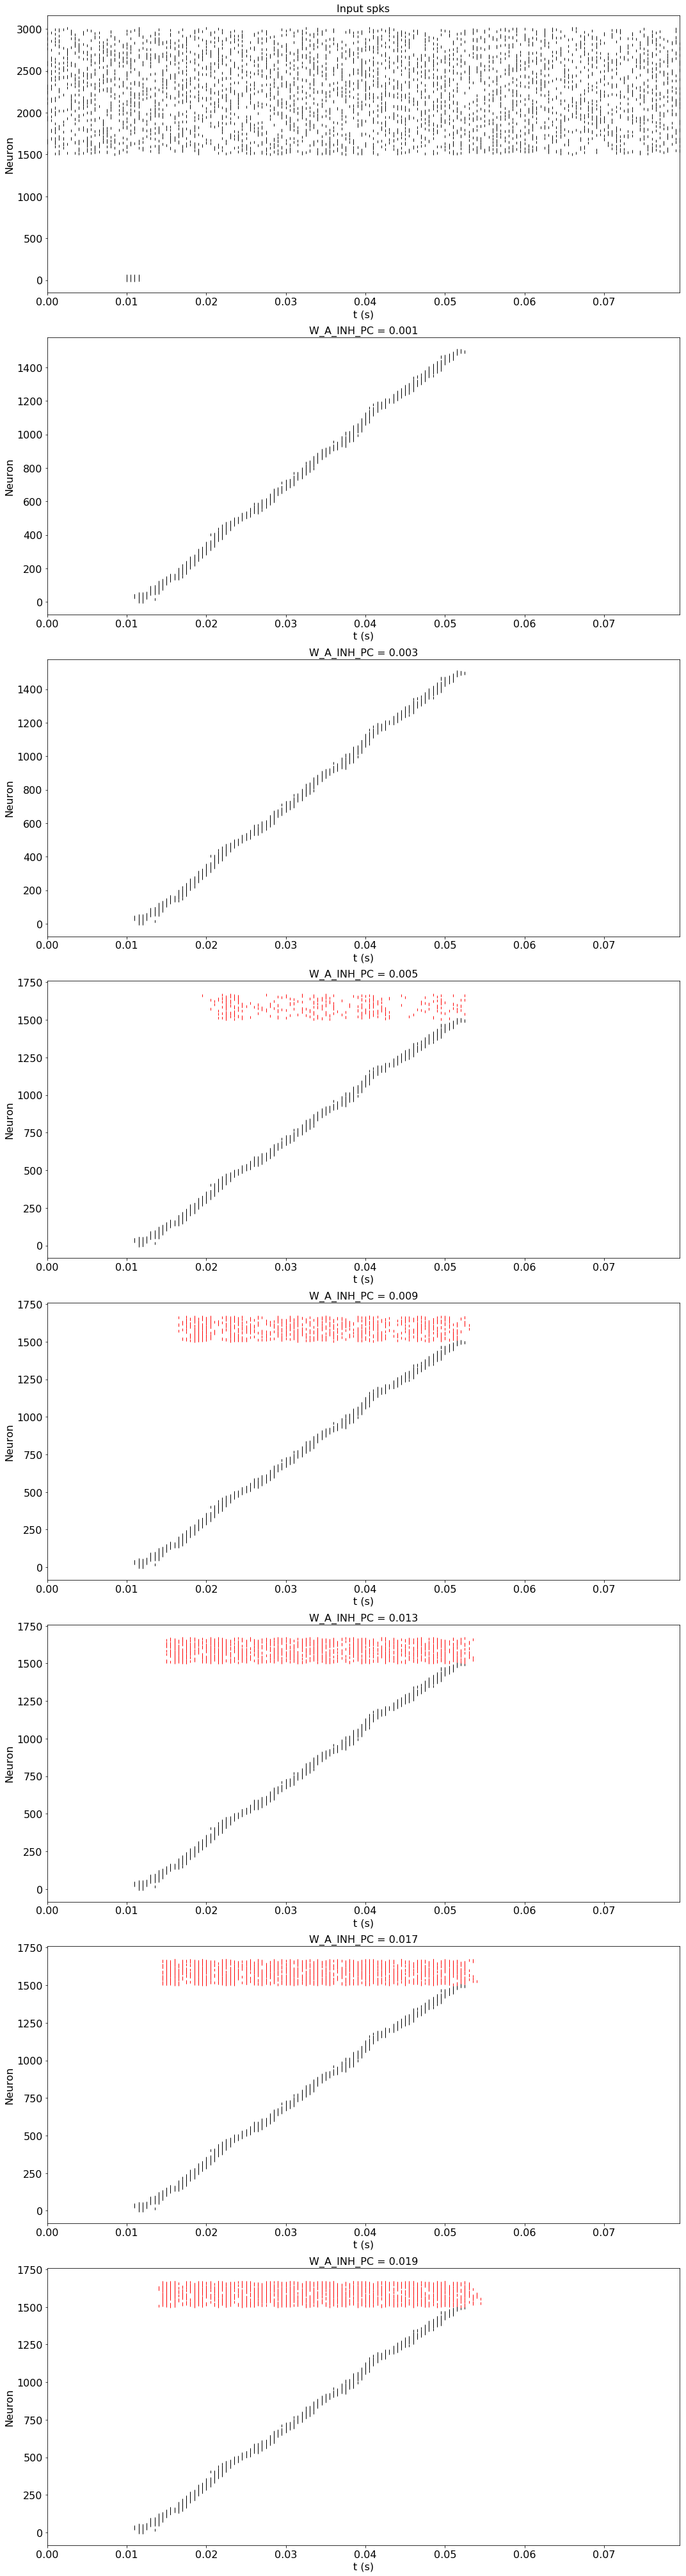

In [7]:
# make plots
n_axs = 1+len(WS_A_INH_PC)
fig_size = (15, 7*n_axs)
fig, axs = plt.subplots(n_axs, 1, figsize=fig_size, tight_layout=True, squeeze=False)
axs = axs[:, 0]

order_up = cc([x_order, x_order+N_PC])

raster(axs[0], t, spks_up, order=order_up, lw=1, c='k')
axs[0].set_title('Input spks')

order_rcr = cc([x_order, np.arange(N_PC, N)])

for ax, w_a_inh_pc, rsp in zip(axs[1:], WS_A_INH_PC, rsps):
    
    # plot exc spikes
    spks_pc = rsp.spks.copy()
    spks_pc[:, -N_INH:] = 0
    
    raster(ax, t, spks_pc, order=order_rcr, lw=1, c='k')
    
    # plot inh spikes
    spks_inh = rsp.spks.copy()
    spks_inh[:, :N_PC] = 0
    
    raster(ax, t, spks_inh, lw=1, c='r')
    
    ax.set_title('W_A_INH_PC = {}'.format(w_a_inh_pc))
    
for ax in axs:
    set_font_size(ax, 16)

# Full HX Ridge Simulation

We now combine the excitation-only ridge simulation with an inhibitory population in our attempt to control the "operating" point of the network, that is, the average activation during propagation.

### PLOT

* (m x n) ax figure, one row per param set
* 1st col shows excitatory cxn probability curve and inhibitory distribution overlaid atop one another
* later cols show raster plots of activity for different trials